# 🎾 ATP Tennis Match Prediction
**Goal**: Predict match outcomes using pre-match features and Elo ratings.

With XG Boost and Logistic Regrassion

**Basic Advance Features Implementation**
(Creating Features from Base data to Enhance Accuracy)

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
df = pd.read_csv(r"/content/Main Dataset.csv")
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1968-T101,Bombay,Clay,NaN,A,1967-12-28,106,100035,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-T102,Calcutta,NaN,NaN,A,1967-12-28,107,100035,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-T102,Calcutta,NaN,NaN,A,1967-12-28,106,110991,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968-T102,Calcutta,NaN,NaN,A,1967-12-28,105,100035,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-T102,Calcutta,NaN,NaN,A,1967-12-28,104,100119,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Drop post-match columns
post_match_cols = [
    'score', 'minutes',
    'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
    'w_SvGms', 'w_bpSaved', 'w_bpFaced',
    'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon',
    'l_SvGms', 'l_bpSaved', 'l_bpFaced',
    'winner_rank_points', 'loser_rank_points'
]
df.drop(columns=[col for col in post_match_cols if col in df.columns], inplace=True)

# Clean up and prepare date
df['tourney_date'] = pd.to_datetime(df['tourney_date'], errors='coerce')
df.dropna(subset=['winner_id', 'loser_id', 'tourney_date'], inplace=True)
df = df.sort_values('tourney_date').drop_duplicates().reset_index(drop=True)

print("✅ Cleaned data shape:", df.shape)
df.head()

✅ Cleaned data shape: (194996, 27)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,best_of,round,winner_rank,loser_rank
0,1968-T101,Bombay,Clay,NaN,A,1967-12-28,106,100035,NaN,NaN,...,NaN,Premjit Lall,R,NaN,IND,27.1,3,SF,NaN,NaN
1,1968-T101,Bombay,Clay,NaN,A,1967-12-28,103,100051,NaN,NaN,...,NaN,Ilie Nastase,R,183.0,ROU,21.4,3,QF,NaN,NaN
2,1968-T101,Bombay,Clay,NaN,A,1967-12-28,101,100092,NaN,NaN,...,NaN,Jan Kodes,R,175.0,CZE,21.8,3,QF,NaN,NaN
3,1968-T101,Bombay,Clay,NaN,A,1967-12-28,102,110991,NaN,NaN,...,NaN,Jan Kukal,R,NaN,CZE,25.2,3,QF,NaN,NaN
4,1968-T101,Bombay,Clay,NaN,A,1967-12-28,105,100092,NaN,NaN,...,NaN,Jaidip Mukerjea,R,NaN,IND,25.6,3,SF,NaN,NaN


In [4]:
# Added Global Elo + Surface-Specific Elo Ratings

from collections import defaultdict
import pandas as pd # Import pandas if not already imported

# K-factor for Elo
K = 32
BASE_ELO = 1500

# Elo dictionaries
global_elo = defaultdict(lambda: BASE_ELO)
surface_elo = defaultdict(lambda: {"Hard": BASE_ELO, "Clay": BASE_ELO, "Grass": BASE_ELO, "Carpet": BASE_ELO})

# For saving Elo values per match
elo_data = []

for idx, row in df.iterrows():
    w_id = row['winner_id']
    l_id = row['loser_id']
    surface = row['surface']

    # Skip this row if the surface is NaN
    if pd.isna(surface):
        # Append default or placeholder values for this skipped match
        elo_data.append({
            'winner_pre_elo': np.nan, # Or some default value like BASE_ELO
            'loser_pre_elo': np.nan, # Or some default value like BASE_ELO
            'winner_surface_elo': np.nan, # Or some default value like BASE_ELO
            'loser_surface_elo': np.nan, # Or some default value like BASE_ELO
            'global_elo_diff': np.nan, # Or 0 if you prefer
            'surface_elo_diff': np.nan # Or 0 if you prefer
        })
        continue # Skip to the next iteration

    # Get current ratings
    w_global = global_elo[w_id]
    l_global = global_elo[l_id]
    # Ensure the surface exists as a key in the player's surface_elo dictionary
    w_surface = surface_elo[w_id].get(surface, BASE_ELO)
    l_surface = surface_elo[l_id].get(surface, BASE_ELO)


    # Save before match
    elo_data.append({
        'winner_pre_elo': w_global,
        'loser_pre_elo': l_global,
        'winner_surface_elo': w_surface,
        'loser_surface_elo': l_surface,
        'global_elo_diff': w_global - l_global,
        'surface_elo_diff': w_surface - l_surface
    })

    # Update Global Elo
    expected_w = 1 / (1 + 10 ** ((l_global - w_global) / 400))
    expected_l = 1 - expected_w
    global_elo[w_id] += K * (1 - expected_w)
    global_elo[l_id] += K * (0 - expected_l)

    # Update Surface Elo only if surface is valid
    # Ensure the surface exists as a key before updating
    if surface in surface_elo[w_id] and surface in surface_elo[l_id]:
        expected_w_surf = 1 / (1 + 10 ** ((l_surface - w_surface) / 400))
        expected_l_surf = 1 - expected_w_surf
        surface_elo[w_id][surface] += K * (1 - expected_w_surf)
        surface_elo[l_id][surface] += K * (0 - expected_l_surf)
    # else:
    #     # Optionally, handle cases where a player doesn't have a rating for a surface
    #     # This might happen if the surface list in the defaultdict is incomplete.
    #     # Given the defaultdict setup, this 'else' block is unlikely to be hit
    #     # as the surface will be added with the base Elo when first accessed.
    #     pass


# Add elo data to main dataframe
elo_df = pd.DataFrame(elo_data)
# Make sure both dataframes have a unique index before concatenating
df = pd.concat([df.reset_index(drop=True), elo_df], axis=1)
print("✅ Elo ratings added:", df.shape)

✅ Elo ratings added: (194996, 33)


## 🎯 Elo Rating System

We calculate two Elo ratings for each player:
1. **Global Elo**: Tracks player's overall performance across all surfaces
2. **Surface-Specific Elo**: Tracks Elo separately for each surface type (Clay, Hard, Grass, Carpet)

- Initial rating for all players: 1500
- Elo updated after each match
- K-factor = 32 (standard learning rate)

These features are critical because they encode a player's skill level dynamically over time and surface, without needing manual ranking updates.


In [5]:
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,best_of,round,winner_rank,loser_rank,winner_pre_elo,loser_pre_elo,winner_surface_elo,loser_surface_elo,global_elo_diff,surface_elo_diff
0,1968-T101,Bombay,Clay,NaN,A,1967-12-28,106,100035,NaN,NaN,...,3,SF,NaN,NaN,1500.0,1500.0,1500.0,1500.0,0.0,0.0
1,1968-T101,Bombay,Clay,NaN,A,1967-12-28,103,100051,NaN,NaN,...,3,QF,NaN,NaN,1484.0,1500.0,1484.0,1500.0,-16.0,-16.0
2,1968-T101,Bombay,Clay,NaN,A,1967-12-28,101,100092,NaN,NaN,...,3,QF,NaN,NaN,1500.0,1500.0,1500.0,1500.0,0.0,0.0
3,1968-T101,Bombay,Clay,NaN,A,1967-12-28,102,110991,NaN,NaN,...,3,QF,NaN,NaN,1500.0,1500.0,1500.0,1500.0,0.0,0.0
4,1968-T101,Bombay,Clay,NaN,A,1967-12-28,105,100092,NaN,NaN,...,3,SF,NaN,NaN,1516.0,1516.0,1516.0,1516.0,0.0,0.0


In [6]:
# Building H2H Features

from collections import defaultdict

# Head-to-head record: stores (player1, player2) -> [player1 wins, total matches]
h2h_record = defaultdict(lambda: [0, 0])

# For storing match-by-match H2H stats
h2h_features = []

for idx, row in df.iterrows():
    w_id = row['winner_id']
    l_id = row['loser_id']

    # Create consistent (small_id, large_id) tuple
    pair = tuple(sorted([w_id, l_id]))

    # Who is player1 in this row? (random later — for now, winner is p1)
    p1 = w_id
    p2 = l_id

    # Get head-to-head history
    wins_p1, total_matches = h2h_record[pair]

    # Save H2H stats
    if total_matches > 0:
        winrate_p1 = wins_p1 / total_matches
    else:
        winrate_p1 = 0.5  # neutral if no history

    h2h_features.append({
        'h2h_total_matches': total_matches,
        'h2h_wins_player1': wins_p1,
        'h2h_winrate_p1': winrate_p1
    })

    # Update H2H record
    if p1 == min(pair):  # p1 was smaller ID
        h2h_record[pair][0] += 1  # player with lower ID won
    h2h_record[pair][1] += 1  # total matches

In [7]:
h2h_df = pd.DataFrame(h2h_features)
df = pd.concat([df.reset_index(drop=True), h2h_df], axis=1)
print("✅ H2H features added:", df.shape)
df[['winner_id', 'loser_id', 'h2h_total_matches', 'h2h_wins_player1', 'h2h_winrate_p1']].head()

✅ H2H features added: (194996, 36)


,winner_id,loser_id,h2h_total_matches,h2h_wins_player1,h2h_winrate_p1
0,100035,100051,0,0,0.5
1,100051,100119,0,0,0.5
2,100092,100113,0,0,0.5
3,110991,100070,0,0,0.5
4,100092,110991,0,0,0.5


## 🔁 Head-to-Head Features

We track the historical record between each pair of players before each match.

Features added:
- `h2h_total_matches`: How many times these two have played before
- `h2h_wins_player1`: How many of those player1 has won
- `h2h_winrate_p1`: Win rate of player1 in H2H history

This allows the model to learn rivalry effects and performance trends between the same opponents.


In [8]:
# Rolling Winrate

from collections import deque

# Rolling window size
N = 10

# Stores player_id -> deque of last N results (1=win, 0=loss)
recent_results = defaultdict(lambda: deque(maxlen=N))

# For saving features
form_data = []

for idx, row in df.iterrows():
    w_id = row['winner_id']
    l_id = row['loser_id']

    # Calculate winrate over last N matches
    w_past = recent_results[w_id]
    l_past = recent_results[l_id]

    w_form = sum(w_past) / len(w_past) if w_past else 0.5
    l_form = sum(l_past) / len(l_past) if l_past else 0.5

    form_data.append({
        'winner_recent_winrate': w_form,
        'loser_recent_winrate': l_form,
        'recent_form_diff': w_form - l_form
    })

    # Update after match
    recent_results[w_id].append(1)
    recent_results[l_id].append(0)

In [9]:
form_df = pd.DataFrame(form_data)
df = pd.concat([df.reset_index(drop=True), form_df], axis=1)
print("✅ Recent form features added:", df.shape)
df[['winner_id', 'loser_id', 'winner_recent_winrate', 'loser_recent_winrate', 'recent_form_diff']].head()

✅ Recent form features added: (194996, 39)


,winner_id,loser_id,winner_recent_winrate,loser_recent_winrate,recent_form_diff
0,100035,100051,0.5,0.5,0.0
1,100051,100119,0.0,0.5,-0.5
2,100092,100113,0.5,0.5,0.0
3,110991,100070,0.5,0.5,0.0
4,100092,110991,1.0,1.0,0.0


## 🔂 Rolling Win Rate (Recent Form)

We track how well each player has been performing over their last 10 matches (rolling window).

Features added:
- `winner_recent_winrate` & `loser_recent_winrate`: win ratio in past 10 matches
- `recent_form_diff`: difference between them (used as a model feature)

This helps the model identify players who are currently on a hot streak or losing streak.


In [10]:
# Match Count in Last 30 Days (Fatigue Estimate)

from collections import defaultdict
import datetime

# Dictionary to hold match dates per player
match_history = defaultdict(list)

fatigue_data = []

for idx, row in df.iterrows():
    match_date = row['tourney_date']
    w_id = row['winner_id']
    l_id = row['loser_id']

    # Count matches in last 30 days for winner
    w_matches = match_history[w_id]
    w_recent = [d for d in w_matches if 0 < (match_date - d).days <= 30]
    w_fatigue = len(w_recent)

    # Count matches in last 30 days for loser
    l_matches = match_history[l_id]
    l_recent = [d for d in l_matches if 0 < (match_date - d).days <= 30]
    l_fatigue = len(l_recent)

    fatigue_data.append({
        'winner_30day_matches': w_fatigue,
        'loser_30day_matches': l_fatigue,
        'fatigue_diff': w_fatigue - l_fatigue
    })

    # Update match history
    match_history[w_id].append(match_date)
    match_history[l_id].append(match_date)

In [11]:
fatigue_df = pd.DataFrame(fatigue_data)
df = pd.concat([df.reset_index(drop=True), fatigue_df], axis=1)
print("✅ Fatigue features added:", df.shape)
df[['winner_30day_matches', 'loser_30day_matches', 'fatigue_diff']].head()

✅ Fatigue features added: (194996, 42)


,winner_30day_matches,loser_30day_matches,fatigue_diff
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


## 🧪 Fatigue Estimation (Matches in Last 30 Days)

Players with too many recent matches may be fatigued, and those with too few may be rusty.

We track:
- Number of matches played by each player in the 30 days before the current match
- Difference in match counts as `fatigue_diff`

This feature helps model the stamina or rest effect on performance.


In [12]:
# Assigning Player 1 / Player 2 & Create Label

import numpy as np

final_data = []

for idx, row in df.iterrows():
    if np.random.rand() < 0.5:
        # Player 1 = winner
        final_data.append({
            'player_1_id': row['winner_id'],
            'player_2_id': row['loser_id'],
            'elo_diff': row['global_elo_diff'],
            'surface_elo_diff': row['surface_elo_diff'],
            'h2h_winrate': row['h2h_winrate_p1'],
            'form_diff': row['recent_form_diff'],
            'fatigue_diff': row['fatigue_diff'],
            'label': 1
        })
    else:
        # Player 1 = loser
        final_data.append({
            'player_1_id': row['loser_id'],
            'player_2_id': row['winner_id'],
            'elo_diff': -row['global_elo_diff'],
            'surface_elo_diff': -row['surface_elo_diff'],
            'h2h_winrate': 1 - row['h2h_winrate_p1'],
            'form_diff': -row['recent_form_diff'],
            'fatigue_diff': -row['fatigue_diff'],
            'label': 0
        })

final_df = pd.DataFrame(final_data)
print("✅ Final formatted dataset shape:", final_df.shape)
final_df.head()

✅ Final formatted dataset shape: (194996, 8)


,player_1_id,player_2_id,elo_diff,surface_elo_diff,h2h_winrate,form_diff,fatigue_diff,label
0,100035,100051,0.0,0.0,0.5,0.0,0,1
1,100051,100119,-16.0,-16.0,0.5,-0.5,0,1
2,100113,100092,-0.0,-0.0,0.5,-0.0,0,0
3,100070,110991,-0.0,-0.0,0.5,-0.0,0,0
4,110991,100092,-0.0,-0.0,0.5,-0.0,0,0


## 🎯 Final Match Formatting (Player1 vs Player2)

We randomly assign one player as `player_1` and the other as `player_2`.  
If `player_1` is the actual winner, label = 1.  
Otherwise, label = 0.

This helps prevent the model from learning "winner always in column X".


In [13]:
# Train & Evaluate XGBoost Classifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define features and target
features = ['elo_diff', 'surface_elo_diff', 'h2h_winrate', 'form_diff', 'fatigue_diff']
X = final_df[features]
y = final_df['label']

# Step 2: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train XGBoost
model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model.fit(X_train, y_train)

# Step 4: Predict & Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"🔍 Accuracy: {acc:.4f}\n")
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:33:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 Accuracy: 0.6780

📊 Confusion Matrix:
[[13245  6149]
 [ 6409 13197]]

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.68     19394
           1       0.68      0.67      0.68     19606

    accuracy                           0.68     39000
   macro avg       0.68      0.68      0.68     39000
weighted avg       0.68      0.68      0.68     39000



/tmp/ipython-input-14-1893450063.py:10: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


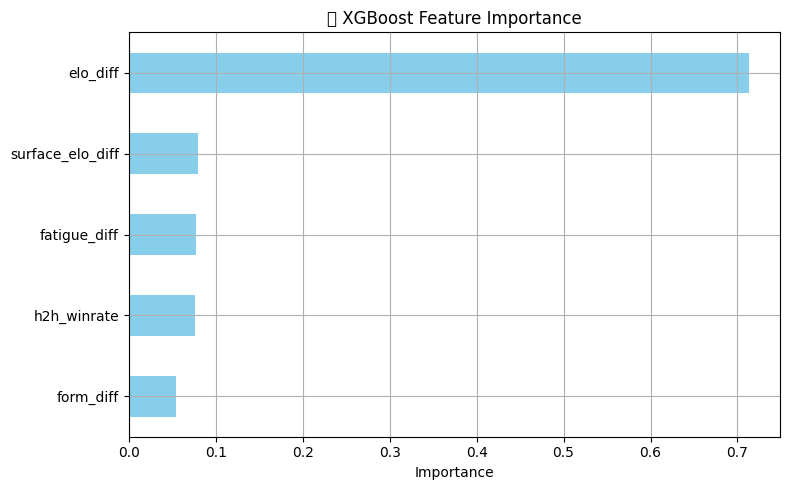

In [14]:
# Feature importance
importances = model.feature_importances_
feat_importance = pd.Series(importances, index=features)

plt.figure(figsize=(8, 5))
feat_importance.sort_values().plot(kind='barh', color='skyblue')
plt.title("🎯 XGBoost Feature Importance")
plt.xlabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()

# Parametes Tuning

Using some different Approch

In [15]:
# Select full set of useful pre-match features
full_features_df = df[[
    'surface', 'round', 'tourney_level', 'draw_size', 'best_of',
    'winner_id', 'loser_id',
    'winner_rank', 'loser_rank',
    'winner_hand', 'loser_hand',
    'winner_ht', 'loser_ht',
    'winner_age', 'loser_age',
    'global_elo_diff', 'surface_elo_diff',
    'h2h_winrate_p1', 'recent_form_diff', 'fatigue_diff'
]].copy()

In [16]:
# Fill missing numeric values with median
numeric_cols = ['winner_rank', 'loser_rank', 'winner_ht', 'loser_ht', 'winner_age', 'loser_age']
for col in numeric_cols:
    full_features_df[col].fillna(full_features_df[col].median(), inplace=True)

# Fill categorical missing values
full_features_df['winner_hand'].fillna('U', inplace=True)
full_features_df['loser_hand'].fillna('U', inplace=True)
full_features_df['draw_size'].fillna(32, inplace=True)

df.head()

/tmp/ipython-input-16-3638006013.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_features_df[col].fillna(full_features_df[col].median(), inplace=True)
/tmp/ipython-input-16-3638006013.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,surface_elo_diff,h2h_total_matches,h2h_wins_player1,h2h_winrate_p1,winner_recent_winrate,loser_recent_winrate,recent_form_diff,winner_30day_matches,loser_30day_matches,fatigue_diff
0,1968-T101,Bombay,Clay,NaN,A,1967-12-28,106,100035,NaN,NaN,...,0.0,0,0,0.5,0.5,0.5,0.0,0,0,0
1,1968-T101,Bombay,Clay,NaN,A,1967-12-28,103,100051,NaN,NaN,...,-16.0,0,0,0.5,0.0,0.5,-0.5,0,0,0
2,1968-T101,Bombay,Clay,NaN,A,1967-12-28,101,100092,NaN,NaN,...,0.0,0,0,0.5,0.5,0.5,0.0,0,0,0
3,1968-T101,Bombay,Clay,NaN,A,1967-12-28,102,110991,NaN,NaN,...,0.0,0,0,0.5,0.5,0.5,0.0,0,0,0
4,1968-T101,Bombay,Clay,NaN,A,1967-12-28,105,100092,NaN,NaN,...,0.0,0,0,0.5,1.0,1.0,0.0,0,0,0


In [17]:
from sklearn.preprocessing import LabelEncoder

le_hand = LabelEncoder()
le_surface = LabelEncoder()
le_round = LabelEncoder()
le_level = LabelEncoder()

full_features_df['winner_hand'] = le_hand.fit_transform(full_features_df['winner_hand'])
full_features_df['loser_hand'] = le_hand.transform(full_features_df['loser_hand'])

full_features_df['surface'] = le_surface.fit_transform(full_features_df['surface'])
full_features_df['round'] = le_round.fit_transform(full_features_df['round'])
full_features_df['tourney_level'] = le_level.fit_transform(full_features_df['tourney_level'])

# Now assign player_1 / player_2 randomly and create label
full_final_data = []

for _, row in full_features_df.iterrows():
    if np.random.rand() < 0.5:
        label = 1
        full_final_data.append({
            'surface': row['surface'],
            'round': row['round'],
            'tourney_level': row['tourney_level'],
            'draw_size': row['draw_size'],
            'best_of': row['best_of'],
            'p1_rank': row['winner_rank'], 'p2_rank': row['loser_rank'],
            'p1_hand': row['winner_hand'], 'p2_hand': row['loser_hand'],
            'p1_ht': row['winner_ht'], 'p2_ht': row['loser_ht'],
            'p1_age': row['winner_age'], 'p2_age': row['loser_age'],
            'elo_diff': row['global_elo_diff'],
            'surface_elo_diff': row['surface_elo_diff'],
            'h2h_winrate': row['h2h_winrate_p1'],
            'form_diff': row['recent_form_diff'],
            'fatigue_diff': row['fatigue_diff'],
            'label': label
        })
    else:
        label = 0
        full_final_data.append({
            'surface': row['surface'],
            'round': row['round'],
            'tourney_level': row['tourney_level'],
            'draw_size': row['draw_size'],
            'best_of': row['best_of'],
            'p1_rank': row['loser_rank'], 'p2_rank': row['winner_rank'],
            'p1_hand': row['loser_hand'], 'p2_hand': row['winner_hand'],
            'p1_ht': row['loser_ht'], 'p2_ht': row['winner_ht'],
            'p1_age': row['loser_age'], 'p2_age': row['winner_age'],
            'elo_diff': -row['global_elo_diff'],
            'surface_elo_diff': -row['surface_elo_diff'],
            'h2h_winrate': 1 - row['h2h_winrate_p1'],
            'form_diff': -row['recent_form_diff'],
            'fatigue_diff': -row['fatigue_diff'],
            'label': label
        })

full_final_df = pd.DataFrame(full_final_data)
print("✅ Full feature dataset shape:", full_final_df.shape)


✅ Full feature dataset shape: (194996, 19)


In [18]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define input and target
X = full_final_df.drop(columns=['label'])
y = full_final_df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train XGBoost
xgb_full = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb_full.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_full.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"🔍 Full Feature XGBoost Accuracy: {accuracy:.4f}\n")
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:33:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 Full Feature XGBoost Accuracy: 0.7671

📊 Confusion Matrix:
[[14964  4561]
 [ 4523 14952]]

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77     19525
           1       0.77      0.77      0.77     19475

    accuracy                           0.77     39000
   macro avg       0.77      0.77      0.77     39000
weighted avg       0.77      0.77      0.77     39000



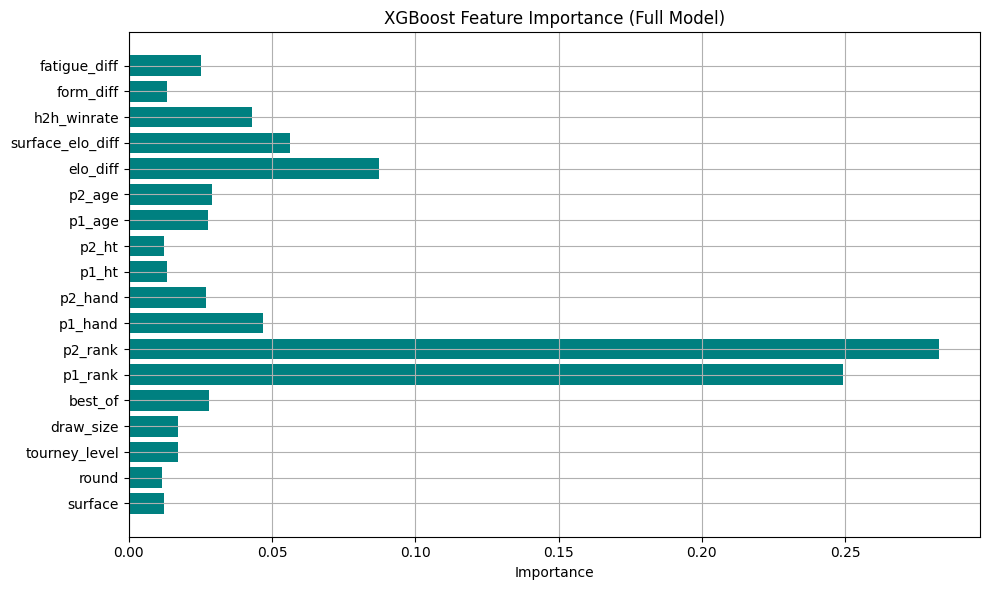

In [19]:
# Plot feature importance
import matplotlib.pyplot as plt

importances = xgb_full.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='teal')
plt.xlabel("Importance")
plt.title("XGBoost Feature Importance (Full Model)")
plt.grid(True)
plt.tight_layout()
plt.show()


## 🚀 Training XGBoost on Full Feature Dataset

Now we use all available structured features:
- Player stats (rank, hand, height, age)
- Match context (surface, round, level, draw)
- Engineered features (elo, fatigue, H2H)

### 📊 Evaluated using:
- Accuracy
- Confusion Matrix
- Classification Report

We also visualize feature importances.



# Moving Forward to Improve Accuracy

In [20]:
# XGBoost Hyperparameter Tuning (Grid/Random Search)

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# Define the parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Instantiate model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Run randomized search
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best parameters & evaluation
print("✅ Best Parameters Found:")
print(random_search.best_params_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🔍 Tuned XGBoost Accuracy:", accuracy_score(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:38:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Best Parameters Found:
{'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 1.0}

🔍 Tuned XGBoost Accuracy: 0.7693076923076924


## 🎯 Step 1: XGBoost Hyperparameter Tuning

We used RandomizedSearchCV over key parameters like:
- n_estimators
- max_depth
- learning_rate
- subsample, colsample_bytree
- gamma, reg_alpha, reg_lambda

This tuning helps reduce overfitting and improve generalization.


In [21]:
# Light BGM

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define and train LightGBM
lgb_model = LGBMClassifier(
    objective='binary',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_lambda=1.5,
    reg_alpha=0,
    random_state=42
)

lgb_model.fit(X_train, y_train)

# Evaluate
y_pred_lgb = lgb_model.predict(X_test)
print(f"🔍 LightGBM Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 77898, number of negative: 78098
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1993
[LightGBM] [Info] Number of data points in the train set: 155996, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499359 -> initscore=-0.002564
[LightGBM] [Info] Start training from score -0.002564
🔍 LightGBM Accuracy: 0.7675

📊 Confusion Matrix:
[[15001  4524]
 [ 4543 14932]]

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77     19525
           1       0.77      0.77      0.77     19475

    accuracy                           0.77     39000
   macro avg       0.77      0.77      0.77     39000
weighted avg       0.77      0.77      0.77     39000



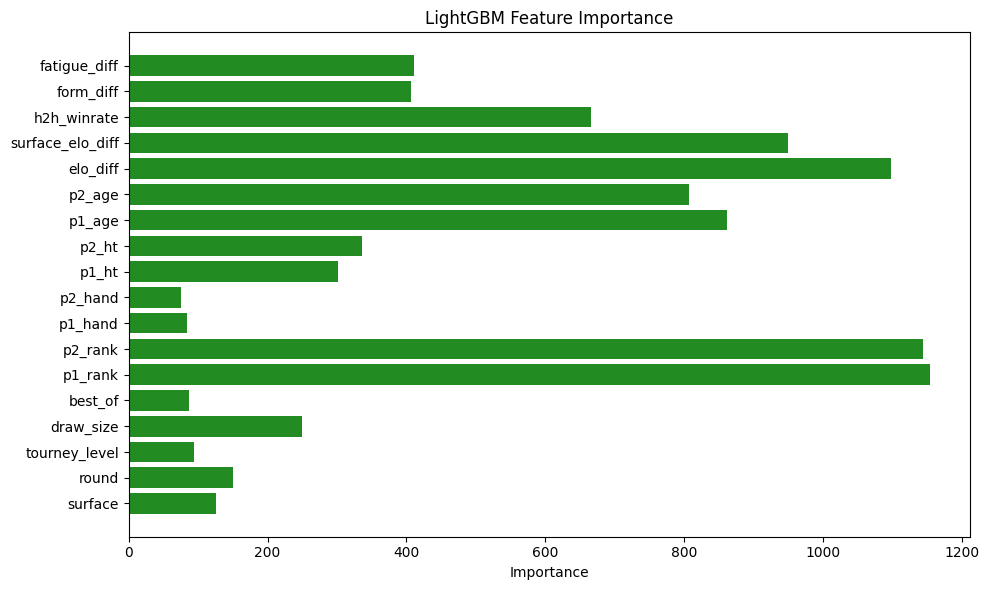

In [22]:
import matplotlib.pyplot as plt

importances = lgb_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='forestgreen')
plt.title("LightGBM Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## ⚡ Step 2: LightGBM Model Training

LightGBM is an efficient gradient boosting algorithm that often outperforms XGBoost on tabular data.

We trained it with the same parameters as the tuned XGBoost model and compared accuracy, precision, and recall.


In [23]:
# Ensemble – Voting Classifier (XGBoost + LightGBM)

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Wrap models
voting_model = VotingClassifier(
    estimators=[
        ('xgb', best_model),     # tuned XGBoost
        ('lgbm', lgb_model)      # trained LightGBM
    ],
    voting='soft'  # use predicted probabilities
)

# Train on training set
voting_model.fit(X_train, y_train)

# Predict
y_pred_ensemble = voting_model.predict(X_test)

# Evaluation
print(f"🔁 Ensemble Accuracy: {accuracy_score(y_test, y_pred_ensemble):.4f}")
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ensemble))
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:39:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 77898, number of negative: 78098
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1993
[LightGBM] [Info] Number of data points in the train set: 155996, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499359 -> initscore=-0.002564
[LightGBM] [Info] Start training from score -0.002564
🔁 Ensemble Accuracy: 0.7683

📊 Confusion Matrix:
[[15034  4491]
 [ 4544 14931]]

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77     19525
           1       0.77      0.77      0.77     19475

    accuracy                           0.77     39000
   macro avg       0.77      0.77      0.77     39000
weighted avg       0.77      0.77      0.77     39000



## 🔁 Step 3: Voting Ensemble (XGBoost + LightGBM)

We combined the strengths of two tuned models using a soft-voting ensemble.

- Voting method: **Soft** (based on probabilities)
- Goal: Slightly boost accuracy by leveraging complementary strengths

Ensembles typically give more stable and generalizable predictions.


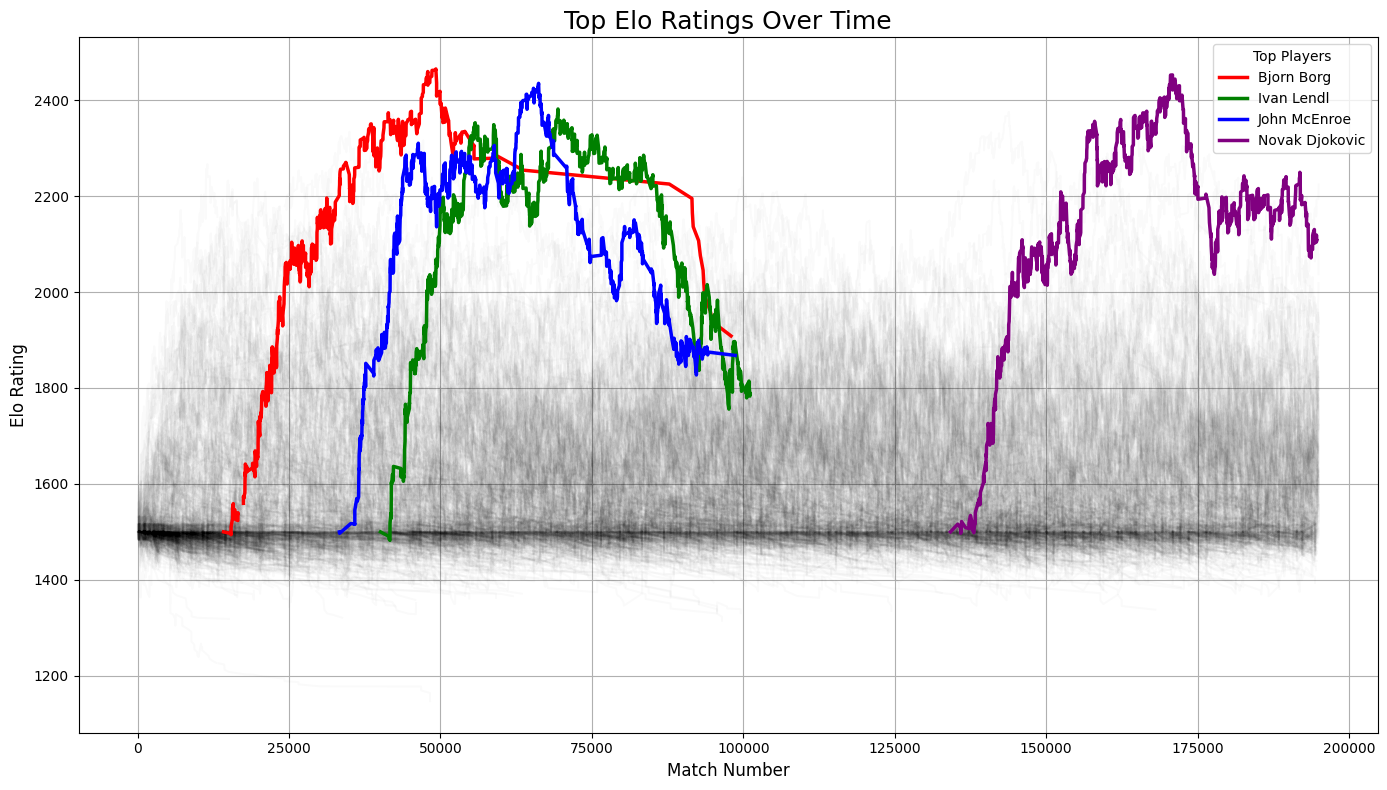

In [25]:
# Visualize ELO

import pandas as pd
import matplotlib.pyplot as plt

# Assuming df has: winner_name, loser_name, winner_pre_elo, loser_pre_elo
elo_progress = []

for idx, row in df.iterrows():
    elo_progress.append({
        'name': row['winner_name'],
        'elo': row['winner_pre_elo'],
        'match_number': idx
    })
    elo_progress.append({
        'name': row['loser_name'],
        'elo': row['loser_pre_elo'],
        'match_number': idx
    })

elo_df = pd.DataFrame(elo_progress)

# 💡 Identify top Elo players (those who've crossed 2200 at least once)
max_elos = elo_df.groupby('name')['elo'].max()
top_players = max_elos[max_elos > 2380].index.tolist()

# 🎨 Plot
plt.figure(figsize=(14, 8))

# Plot all players faintly
for player in elo_df['name'].unique():
    player_df = elo_df[elo_df['name'] == player]
    plt.plot(player_df['match_number'], player_df['elo'], color='black', alpha=0.02)

# Highlight top performers
colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan']
for i, player in enumerate(top_players):
    player_df = elo_df[elo_df['name'] == player]
    plt.plot(player_df['match_number'], player_df['elo'],
             label=player,
             color=colors[i % len(colors)],
             linewidth=2.5)

# Formatting
plt.title("Top Elo Ratings Over Time", fontsize=18)
plt.xlabel("Match Number", fontsize=12)
plt.ylabel("Elo Rating", fontsize=12)
plt.legend(title="Top Players")
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
# Save your current DataFrame to a CSV file
df.to_csv("custumized_tennis_match_feature_rich_data.csv", index=False)

In [ ]:
# Exporting the model With Features

import joblib

# 1. Save the final trained model and column order
joblib.dump(xgb_full, "xgb_model_final.pkl")
joblib.dump(X.columns.tolist(), "trained_columns.pkl")

# 2. Save the final state of the feature engineering dictionaries
#    (These hold the history needed to calculate features for new matches)
joblib.dump(global_elo, 'global_elo_final.pkl')
joblib.dump(surface_elo, 'surface_elo_final.pkl')
joblib.dump(h2h_record, 'h2h_record_final.pkl')
joblib.dump(recent_results, 'recent_results_final.pkl')
joblib.dump(match_history, 'match_history_final.pkl')

# 3. Save the fitted LabelEncoders for consistent preprocessing
#    (Assuming these are the names of your fitted encoders from the notebook)
encoders = {
    'hand': le_hand,
    'surface': le_surface,
    'round': le_round,
    'level': le_level
}
joblib.dump(encoders, 'label_encoders.pkl')

print("✅ Model, columns, state dictionaries, and encoders saved successfully.")

✅ Model and feature list saved successfully.
